In [52]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv
import copy
import sklearn.linear_model
import json
import re
from sklearn import preprocessing
import networkx as nx
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
from networkx.algorithms import bipartite
from networkx.algorithms import max_weight_matching
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
COLOR_TREAT = "#2ecc71"
COLOR_NO_TREAT = "#e74c3c"
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def percent_categorical(item, df=None, grouper='Active Status' , order = None , title = None , label = None , legend = None) :
    # plot categorical responses to an item ('column name')
    # by percent by group ('diff column name w categorical data')
    # select a data frame (default is IA)
    # 'Active Status' is default grouper

    # create df of item grouped by status
    grouped = (df.groupby(grouper)[item]
    # convert to percentage by group rather than total count
                .value_counts(normalize=True)
                # rename column 
                .rename('percentage')
                # multiple by 100 for easier interpretation
                .mul(100)
                # change order from value to name
                .reset_index()
                .sort_values(item))

    # create plot
    
    f, axarr = plt.subplots(1, 2, figsize = (15,8))
    
    sns.barplot(x=item,
                         y='percentage',
                         hue=grouper,
                         data=grouped,
                         palette='RdBu' , order = order , ax = axarr[0]
                         )
    
    
    
    sns.countplot( x = item , data= df , hue = grouper , palette='RdBu' , order = order , ax = axarr[1])
    
    
    
    
    if title == None:
        title = ['' , '']
    
    axarr[0].set_title(title[0] , size =15)
    axarr[1].set_title(title[1] , size =15)
    if label == None :
        label = item
    axarr[0].set_xlabel(label , size = 15)
    axarr[1].set_xlabel(label , size =15)
    
    axarr[0].tick_params(axis='both', which='major', labelsize=15)
    axarr[1].tick_params(axis='both', which='major', labelsize=15)
    
    axarr[0].set_xticklabels(order , rotation=45 )
    axarr[1].set_xticklabels(order , rotation=45 )
    
    axarr[0].set_ylabel('Percent' , size = 15)
    axarr[1].set_ylabel('Counts',  size =15 )
    
    if legend != None:
        
        for ax in axarr :
            leg_handles = ax.get_legend_handles_labels()[0]
            ax.legend(leg_handles, [legend[1], legend[2]], title=legend[0])
            plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
            plt.setp(ax.get_legend().get_title(), fontsize='15')
    
    return axarr

In [ ]:
flatui = ["#55ff00","#73a659", "#a6595b", "#ff0004"]
sns.palplot(sns.color_palette(flatui))
plt.savefig('legend.png', transparent=True)
plt.xticks()

# Do the United Nations peace agreements have an impact on conflicts resolution around the world ?

# 1. Introduction

The United Nations often gets criticised for all the wars it could not prevent and its impact in our society has often been questioned. The UN exist since 1945, although until today the amount of conflicts around the world has not significantly diminished, does this mean that the UN is inefficient ? The Israelo-Palestinian conflict is allmost as old as the UN and no Peace Agreements could completely stop it as of today, so does the efforts made through the UN organization are worth the results ? Such a question would request more than a statistical study to be answered. Hence, we will focus on studying the impact of the UN in the domain of conflict resolution. 
 
 Our study aims at giving an objective analysis of the impact of UN peace agreements on the evolution of conflicts around the world. We present the results of our analysis as a data story. Information relative to both conflicts and peace treaties are displayed on a world map in order to get an insight on the impact they have on one another.

To perform this, we used the UCDP dataset which provides information about the conflicts and peace agreements from 1975 to 2011.

# 2. Facts about conflicts and Peace Agreements

## 2.1 Conflicts

In [ ]:
#For nb of deaths
precisedf = pd.read_csv('data/ged171.csv')

#Import the Peace Agreement dataset and the translation table to get the new IDs
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]
pa[pa['UN'] == 1]

reader = csv.reader(open('data/translate_conf.csv', 'r'))

#Create a dictionnary that will have {New ID : Old ID} so we can make the link
d = {}
for row in reader:
    k, v = row
    d[v] = k
    
#pa.CID = pa.CID.astype(dtype=str).replace(to_replace=d )
pa.CID = pa.CID.astype(str)
#print(type(pa.CID))
pa.CID = pa.CID.apply(lambda x: d[x])
pa.CID = pa.CID.astype(dtype = int)

#Import the conflict dataset
df = pd.read_csv('data/ucdp-prio-acd-171.csv')
df.drop(['sidea2nd', 'sideb2nd' , 'terr' , 'year' , 'intensity' , 'startprec' , 'startdate2' , 'epend' , 'ependprec', 'gwnoa', 'gwnoa2nd', 'gwnob', 'gwnob2nd', 'gwnoloc', 'startprec2', 'version', 'sidebid'], axis=1, inplace = True)
clean_df = df.groupby('conflictid').last()
agreements = pa.groupby('CID').last()
UN_agreements = pa[pa['UN']==1].groupby('CID').last()
Other_agreements = pa[pa['UN']==0].groupby('CID').last()
clean_df["agreement"] = [1 if ele in agreements.index else 0 for ele in clean_df.index]
clean_df["UN_agreement"] = [1 if ele in UN_agreements.index else 0 for ele in clean_df.index]
clean_df["Other_agreement"] = [1 if ele in Other_agreements.index else 0 for ele in clean_df.index]
clean_df.rename({'ependdate':'enddate'} , inplace = True, axis = 1)
clean_df['startdate'] = pd.to_datetime(clean_df['startdate'])
clean_df['enddate'] = pd.to_datetime(clean_df['enddate'])
clean_df['duration'] = (clean_df['enddate'] - clean_df['startdate']).dt.days
regiondic = {'1':'Europe' , '2': 'Middle East', '3': 'Asia' , '4': 'Africa' , '5':'Americas' , '1, 3' : 'Asia',
            '1, 2' : 'Middle East' , '1, 4':'Africa' ,'1, 5': 'Americas','1, 2, 3, 5' :'Middle East' , '1, 3, 5' : 'Middle East'}
typedic = {1 : 'Extrasystemic' , 2 : 'Interstate' , 3 : 'Internal' , 4: 'Internationalized'}
incompdic = {1 : 'Territory' , 2: 'Government' , 3: 'Government and Territory'}
cumintdic = {0: 'Less than 1000 deaths' , 1: 'More than 1000 deaths'}
clean_df.region.replace(regiondic , inplace= True)
clean_df.type.replace(typedic , inplace= True)
clean_df.incomp.replace(incompdic , inplace = True)
clean_df.cumint.replace(cumintdic , inplace = True)
ag = clean_df[clean_df['agreement'] == 1]
clean_df[clean_df['agreement'] == 1].head()

In [ ]:
clean_df['Year'] = pd.DatetimeIndex(clean_df['startdate']).year

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(x='Year', data=clean_df, hue='agreement' , palette = 'RdBu')
plt.title('Distribution of the conflicts by starting year' , size =15)
plt.xlabel('Year' ,size = 15)
plt.ylabel('Count' , size =15)
plt.xticks(rotation=70 , size = 12)
plt.yticks(size = 12)
plt.legend( ['Without' , 'With'] ,fontsize = 'large' , title = 'Agreement' , )
plt.savefig('images/conflict_year.png', transparent=True)

# `Region` distribution

## With respect to the PA

In this first part, we will study the different conflicts that ta




We observe that the regions are not equally distributed, a large proportion of conflicts that take part in Europe or in Africa benefits from a or several peace agreements whereas there is almost no peace agreements in the Middle East or in Asia. 

The two distributions are indeed very different.

If we look at the percentage of conflicts that received a PA for each regions, we notice that 1/3$^{rd}$ of the conflicts received a peace agreements in Africa, 1/4$^{th}$ in Europe, but only 7% in the Middle East.

In [ ]:
regper = (clean_df[clean_df['agreement'] == 1].groupby('region').count() /(clean_df[clean_df['agreement'] == 0].groupby('region').count() + clean_df[clean_df['agreement'] == 1].groupby('region').count()))['location']
plt.figure(figsize=(15,5))
sns.barplot( x = regper.index , y = (regper.values*100) , color = '#B0CDDD' )
plt.xlabel('Regions' , size = 15)
plt.ylabel('Percent' , size = 15)
plt.xticks(rotation=45 , size = 12)
plt.title('Repartition of the conflicts across the regions' , size = 15)
plt.savefig('images/regionrep.png', transparent=True)

In [ ]:
percent_categorical('region' , df= clean_df , grouper = 'agreement' , 
                    order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East'],
                   title = ['Distribution of conflicts across the regions' , 'Number of conflicts per region'] ,
                    label = 'Region', legend = ['Agreement' , 'without' , 'with'])
plt.savefig('images/RegionAG.png', transparent=True , bbox_inches = 'tight')

## With repsect to the UN

Here we filter the conflicts in order to only vizualize those who benefited from a peace agreements. We want to study if the distribution for the CID that benefited from a PA where the UN were involved is the same as the distribution for the CID that benefited from a PA where the UN were not involved.
Here the distributions are looking alike. The only outliers we would have are for the Middle East and Americas regions. Indeed, in our database the UN never took part in a peace agreement for the Middle East region.

In [ ]:
percent_categorical('region' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East'],
                    title = ['Distribution of the solved conflicts across the regions' , 'Number of solved conflicts per region'] 
                     , label = 'Region' , legend = ['UN intervention' , 'without' , 'with']);
plt.savefig('images/RegionCUN.png', transparent=True , bbox_inches = 'tight')

# `Type` distribution

## With respect to the PAs

The large majority of the conflicts are internal conflicts, followed by internationalized and interstatical conflicts.
Extrasystemic conflicts (represents colonial conflicts) did not receive any peace agreements.
Otherwise, the distribution is almost the same for agreements or not. 

In [ ]:
percent_categorical('type' , df= clean_df , grouper = 'agreement' , 
                    order = ['Extrasystemic' , 'Interstate' , 'Internal' , 'Internationalized'],
                   title = ['Distribution of conflicts type' , 'Number of conflicts per different type'],
                   label = 'Type of conflict' , 
                   legend = ['Agreement' , 'without' , 'with']);
plt.savefig('images/typeAG.png', transparent=True , bbox_inches = 'tight')

## With respect to the UN 

Here we can see a bit of a difference between the distributions. Indeed, when we look at the conflict solved by the UN, Internationalized conflicts represents 20% of it whereas it's less than 10% for the conflicts that received a Peace Agreement but not from the UN.

The UN seem to be more focused on Internationalized conflicts than Interstate conflicts compared to the control distribution.

In [ ]:
percent_categorical('type' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Interstate' , 'Internal' , 'Internationalized'],
                   title = ['Distribution of the solved conflicts by conflict type' , 'Number of conflicts that benefited from a PA per conflict type'],
                   label = 'Type of conflict' , 
                   legend = ['UN intervention' , 'without' , 'with']);
plt.savefig('images/typeCUN.png', transparent=True , bbox_inches = 'tight')

# `Incomp` distribution

## With respect to the agreements

There is very few conflicts that began because of a *Government and Territory* incompatibility. The distribution of the CID that did not receive a peace agreement is strongly around Territorial incompatibility whereas the one for the CID that benifited from an agreement is even between Terrytory and Government incomp.

In [ ]:
percent_categorical('incomp' , df= clean_df , grouper = 'agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'],
                   title = ['Distribution of the incompatibilities' , 'Number of conflicts per different incompatibilities'],
                   label = 'Incompatibility that led to the conflict' ,
                   legend = ['Agreement' , 'without' , 'with'])
plt.savefig('images/incompAG.png', transparent=True , bbox_inches = 'tight')

## With respect to the UN

Here the distributions are very different. Indeed, the distribution for the UN is centered around Government incomp (more than 70% of the conflicts solved by the UN) whereas the conflicts that were not solved by the UN are more centered around conflicts that began because of a Territorial incompatibility.

In [ ]:
percent_categorical('incomp' , df= ag , grouper = 'UN_agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'],
                    title = ['Distribution of the incompatibilities for the solved CIDs' , 'Number of solved conflicts per different incompatibilities'],
                   label = 'Incompatibility that led to the conflict' , 
                   legend = ['UN intervention' , 'without' , 'with'])
plt.savefig('images/incompCUN.png', transparent=True , bbox_inches = 'tight')

# Number of deaths

## With respect to PA

We observe on these distributions that peace agreements focus more on deadly conflicts (more than 1000 deaths during the totality of the conflict) than the less deadly ones. The distribution for the conflict that did not receive a peace agreement is even between the two classes, deadly or less deadly.

In [ ]:
percent_categorical('cumint' , df= clean_df , grouper = 'agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'] ,
                   title = ['Distribution for the number of deaths' , 'Number of conflicts per classes'],
                   label = 'Number of deaths' ,
                   legend = ['Agreement' , 'without' , 'with'])
plt.savefig('images/cumintAG.png', transparent=True, bbox_inches = 'tight')

## With respect to the UN

Here we observe that the UN is way more focused on the deadly conflicts (80% of the conflicts solved by the UN have more than 1000 deaths). For the other solver, they solve both types of conflicts equally. It begins to seem that the UN is taking care of the more difficult conflicts.

In [ ]:
percent_categorical('cumint' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'],
                   title = ['Distribution for the number of deaths for the CIDs with a PA' , 'Number of conflicts per classes for the CIDs with a PA'],
                   label = 'Number of deaths' , 
                   legend = ['UN intervention' , 'without' , 'with'])
plt.savefig('images/cumintCUN.png', transparent=True , bbox_inches = 'tight')

## 2.2 Peace Agreements
The Peace Agreements contain a lot of information about the type of conflict they aim to solve, their own power of violence dissipation and the technicalities that should be set up to bring a more civilized life to the people concerned by the conflict. There are three main types of peace agreements :

-------------- faire un tableau ------------
- Full peace agreement
- Partial peace agreement
- Peace process agreement

--------------faire un tableau---------------

Obviously, this goes from the most executive agreement to the least executive agreement, athough it does not translate the power of a Peace Agreement. Each Peace Agreement is defined by a few charateristics for each type of political provision (a provision is a clause in legal instrument). Below we give a definition for each type of provision.

-------------- faire un tableau ------------
- Behavioral conduct of the warring parties
- Regulation of governmental incompatibility
- Regulation of territorial incompatibility
- Justice issues

-------------- faire un tableau ------------

8 peace agreements with UN. out of the 8 PAs only 1 is still valid as of today
PA with UN represents X% of the PA's. Hence a matching analysis must be made to 

In [53]:
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
cols = ['bwdID', 'pa_comment', 'c_sign', 'c_3rd', 'c_duration', 'Reaffirm ID', 'Comment', 'txt', 
        'Link to fulltext agreement', 'ProcID', 'Frame', 'All', 'Counter' , 'Duration']
pa.drop(columns=cols, inplace=True)
regiondic = {
    1:'Europe',
    2:'Middle East',
    3:'Asia',
    4:'Africa',
    5:'Americas'
}
paType = {1:'Full Peace',2:'Partial Peace',3:'Peace Process'}
incompatibility = {1:'Territorial', 2:'Governmental',3:'Territorial & Governmental'}
endedList = {0:'Still Valid', 1:'Terminated'}
pa['ended'].replace(endedList, inplace=True)
pa['pa_type'].replace(paType, inplace=True)
pa['Region'].replace(regiondic, inplace=True)
pa['Inc'].replace(incompatibility, inplace=True)

searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = ['UN intervention' if ele in inter else 'No UN intervention' for ele in pa.PAID]

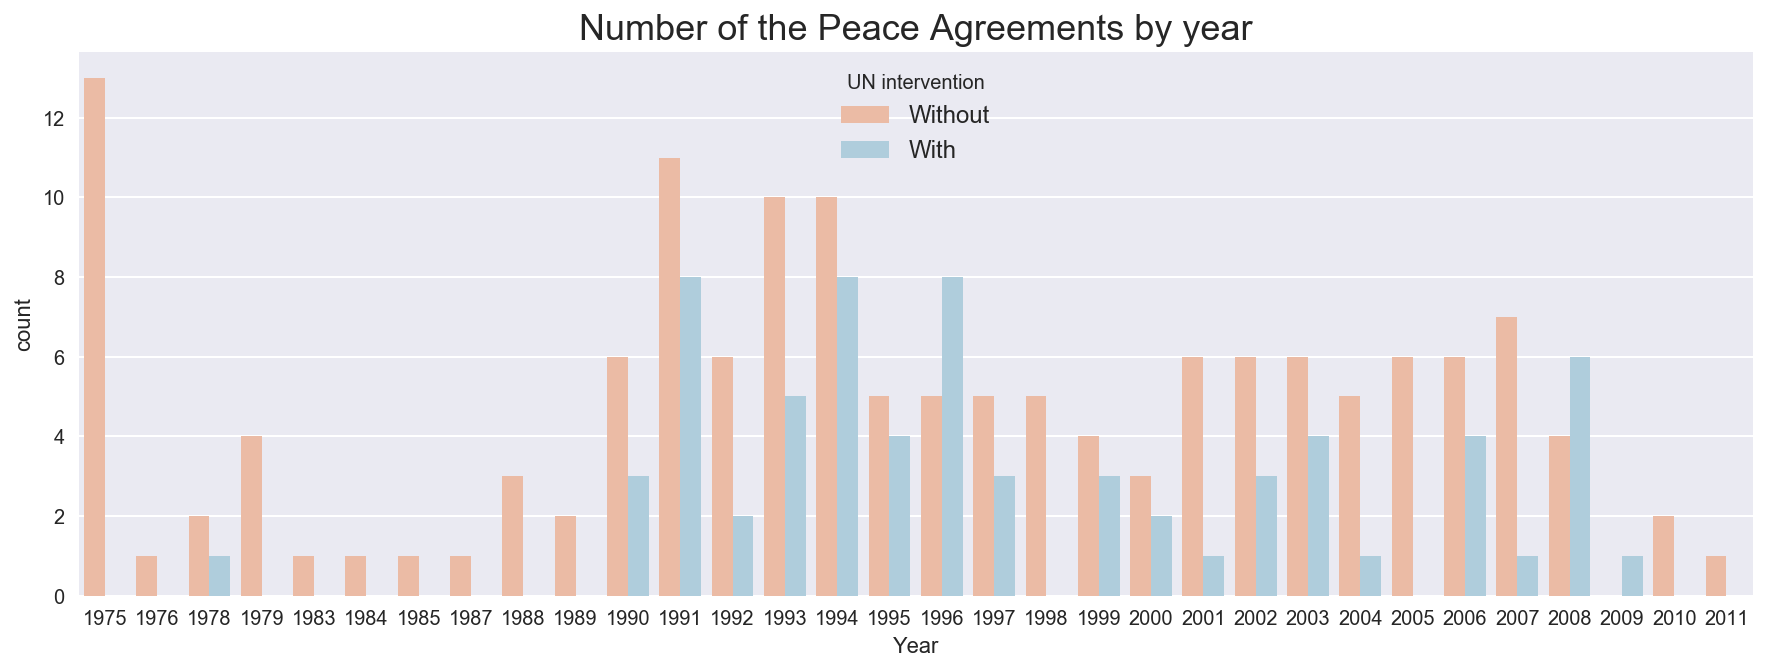

In [69]:
plt.figure(figsize=(15,5))
sns.countplot(x='Year', data=pa, hue='UN', palette='RdBu')
plt.title('Number of the Peace Agreements by year', Fontsize=18)
plt.legend( ['Without' , 'With'] ,fontsize = 'large' , title = 'UN intervention')
plt.savefig('frontend/img/images/PA_year.png', transparent=True, bbox_inches = 'tight')

### Year distibution of Peace agreements
1991 is the year where most peace agreements were signed. There has been two periods with a low amount of peace agreement, from 1983 to 1987 and from 2009 to 2011. Until 1990, The UN were not taking part to Peace agreements except for the Peace Process agreement between Namibia and South Africa in 1978.

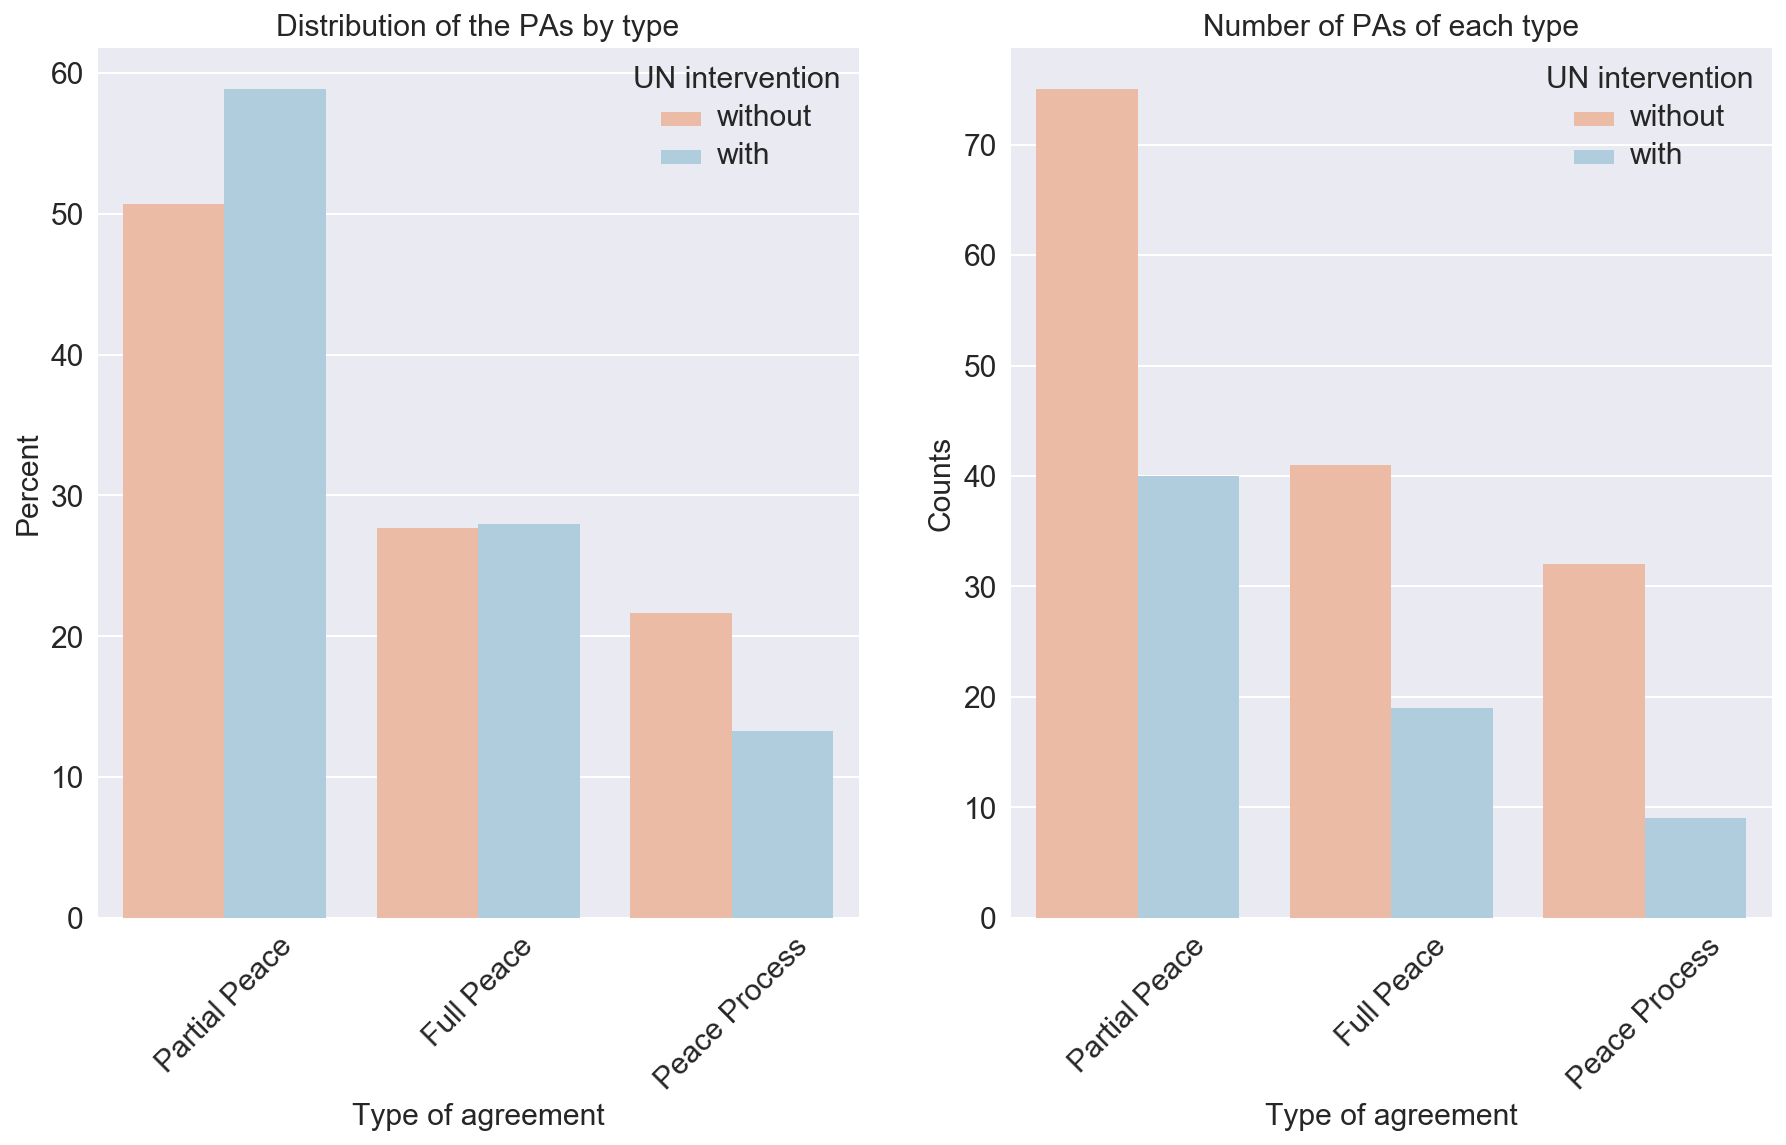

In [71]:
percent_categorical('pa_type' , df=pa , grouper = 'UN' , order = pa.pa_type.value_counts().index,
                   title = ['Distribution of the PAs by type' , 'Number of PAs of each type'],
                   label = 'Type of agreement' , 
                   legend = ['UN intervention' , 'without' , 'with']);
plt.savefig('frontend/img/images/PA_typeInc.png', transparent=True, bbox_inches = 'tight')

### Executive strength of peace agreements
Most peace agreements are partial peace agreements. Peace Process agreements are generally agreements that are signed at the begginning of a conflict and call for future peace agreements. This figure that UN involvment in the peace agreements does not change much the distribution of the the PAs types. 

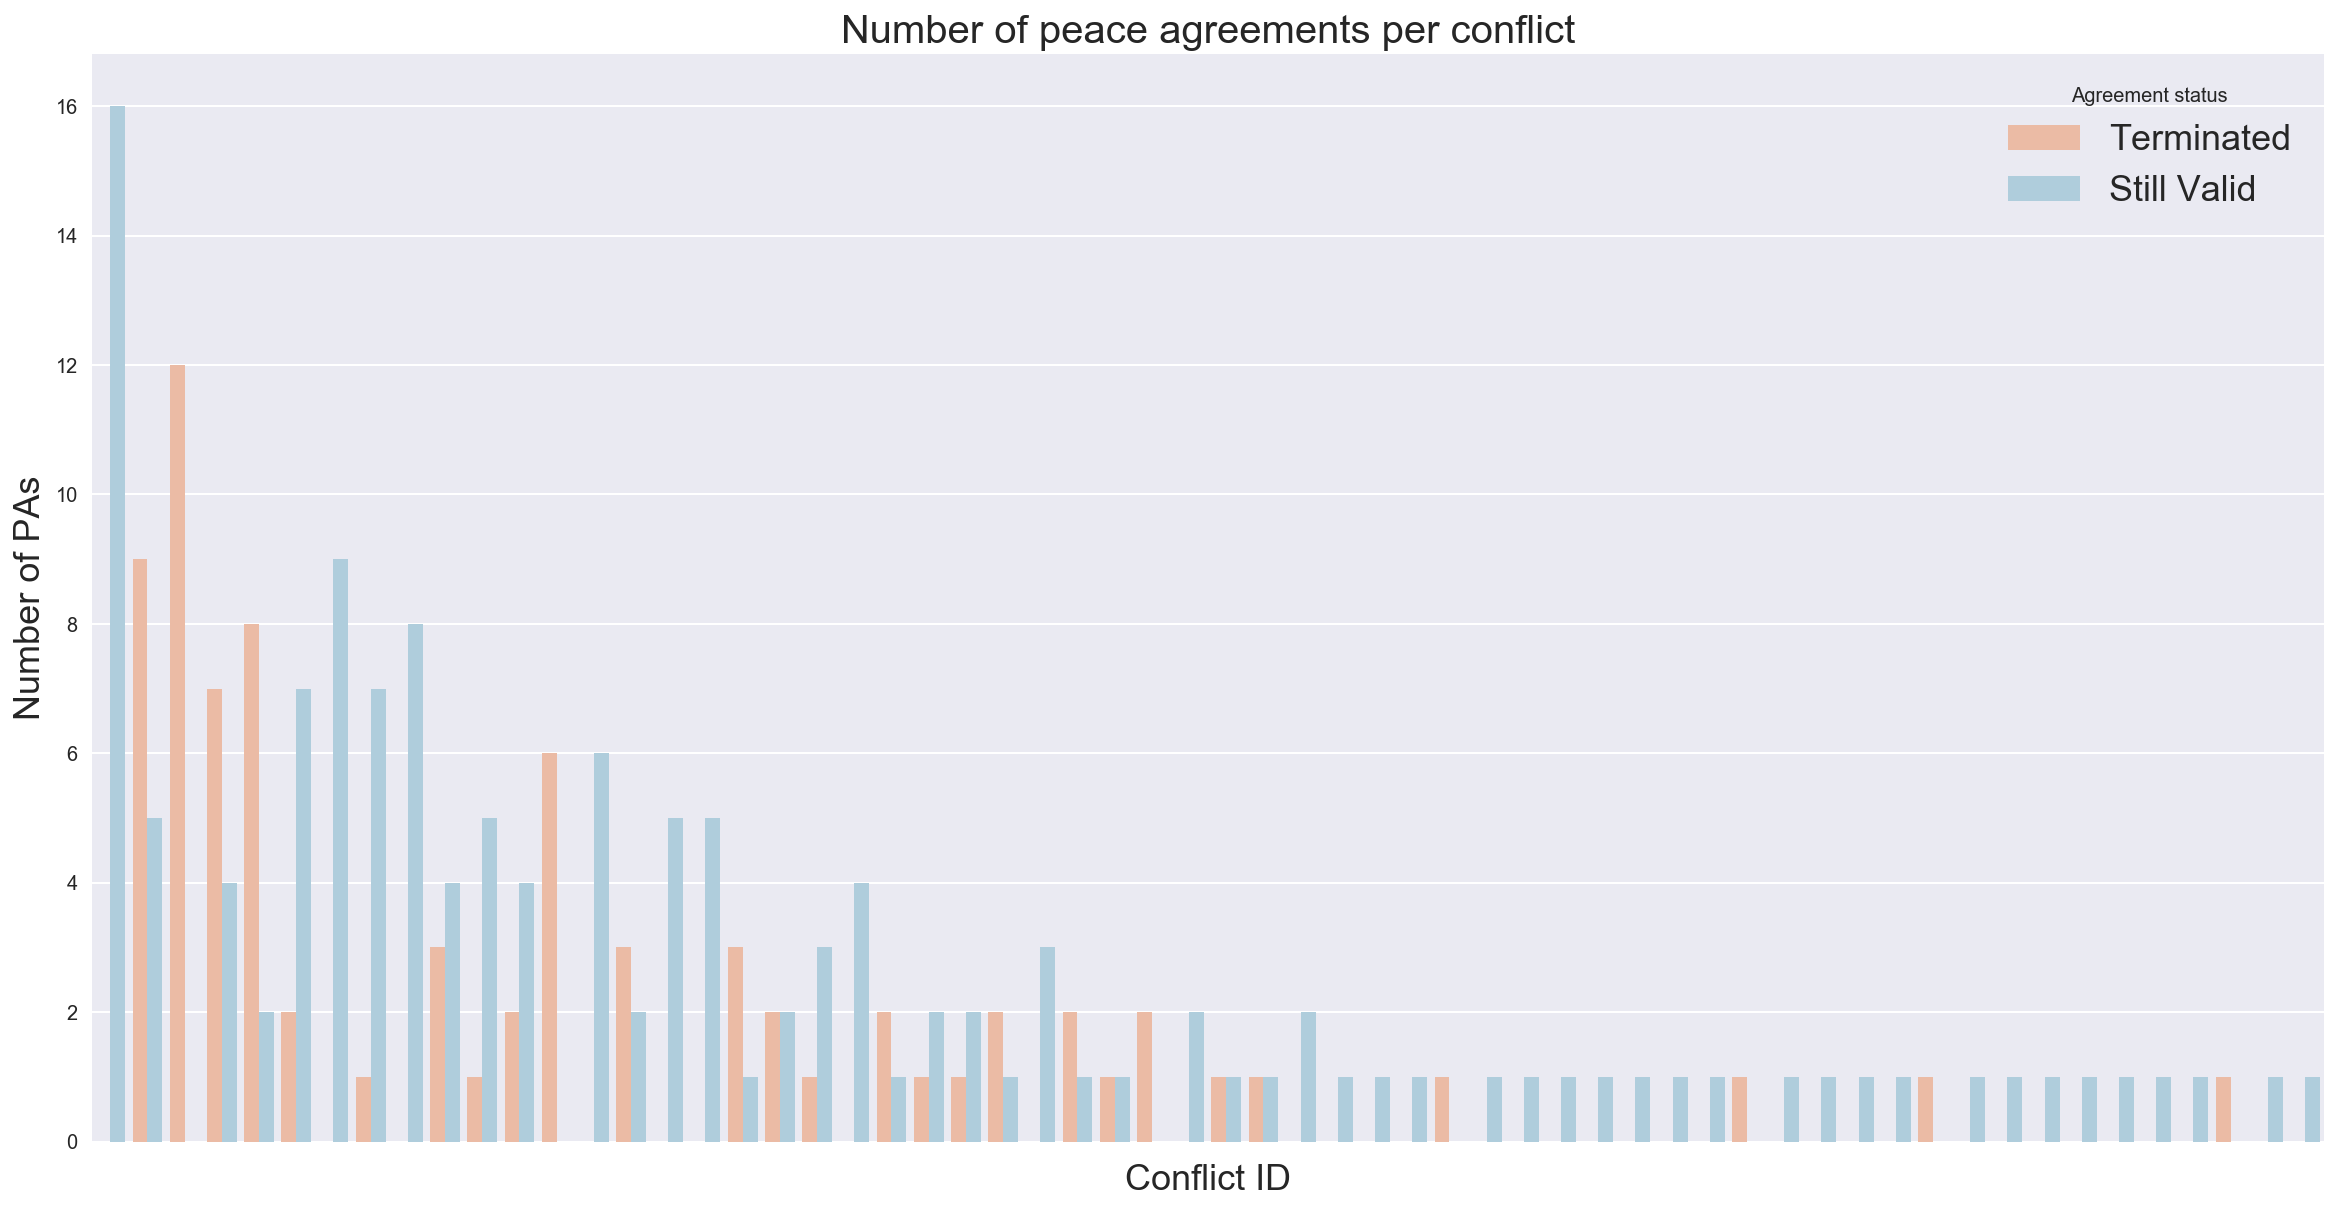

In [66]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='CID', data=pa, hue='ended', order=pa.CID.value_counts().index, palette='RdBu')
plt.legend(['Terminated' , 'Still Valid'] ,fontsize = 'xlarge' , title = 'Agreement status', loc='upper right', prop={'size': 18})
#ax.legend(loc='upper right', prop={'size': 18})
plt.xlabel('Conflict ID', fontsize=18)
plt.ylabel('Number of PAs', fontsize=18)
plt.title('Number of peace agreements per conflict', Fontsize=20)
plt.xticks(np.arange(2), ('', ''))
plt.savefig('frontend/img/images/PA_CID.png', transparent=True)

This figure shows that some conflicts used more than one Peace Agreement. 

Conflict 36 is an example of a conflict where multiple agreements were needed to achieve peace. This conflict concerns the Government of Guatemala and the Guatemalan National Revolutionary Unity. 16 peace agreements were signed in six years and all of them are still valid as of today. 

On the other hand, conflict 128 is an example of a conflict where all of its agreements ended. This conflict was between Iran and Iraq. Each of the 12 agreements were signed in 1975. Despite the first agreements, that was signed by The Shah of Iran and Saddam Hussein, all of them were signed by the same two representatives of Iran and Iraq, respectively by ABBAS-ALI KHALATBARY, Minister for Foreign Affairs of Iran and SAADOUN HAMADI, Minister for Foreign Affairs of Iraq. These agreements that were active in 1975, were than terminated between 1975 and 1980 until they were reactivated. Although the agreements were reactivated in 1980. Conflicts between Iran and Iraq did not stop in 1980, hence we can consider those agreements as failures.

**Conflict 179 :**

This conflict concerned the Government of the Republic of Rwanda and the Rwandese Patriotic Front. The six agreements were signed between 1992 and 1993. The incompatibility is governmental.
The five first agreements were signed to provide partial peace and the last one in august 1993 was supposed to prvide full peace to the region. None of the agreements provided for the holding of national talks to solve incompatibility and for the integration of rebels into civil service.
In April 1994, a genocide broke out and the peace agreements were never fully implemented.

**Conflict 101 : **

This conflict originated from a governmental incompatibility between South Africa and Namibia. The agreement was signed in 1978 and lasted two months. The agreement contained provisions for political incompatibilities leading to independence for Namibia, justice provisions with the return of refugees and release of political prisoners and behavior regulations such as (ceasefire, withdrawal of foreign forces and demobilisation of local armies).
 
**Conflict 216 : **

Government of Guinea Bissau - Military Junta for the Consolidation of Democracy, Peace and Justice. Incompatibility 2, The peace agreement lasted for 6 months.

** Conflict 205 : **

The agreement covered indigenous rights and culture and strengthened the position of the indigenous people in Mexico. incompatibility 2. The accord was never implemented and thus further peace talks that were planned in September the same year were suspended by EZLN. No exact date for the ending of the peace accord has been found.

All of the conflicts that were treated by only one agreement and had terminated originated from governmental imcompabilities. 

### Regulation of warring parties behavior
Most Peace Agreements that contain behavioral clauses provide for a ceasefire and the disarmement of foreign forces. Two kinds of agreements were never terminated, the ones which provided for the creation of a new national army or the integration of rebels into the army and the withdrawal of foreign forces.

### Regulation of governmental incompatibilities
72% of the Peace agreements concern governmental incompabiliities.
Peace agreements that provide governmental provisions mostly provide for elections and electoral reforms for rebel integration into the interim government. The main difference that can be observed between UN agreements and non UN agreements is that the UN agreements usually provide provisions for an interim government and elections while non UN agreements msotly only provide provisions for an election.

### Regulation of territorial incompatibilities
Territorial conflicts are mostly treated by Peace Agreements with clauses about the demarcation of a border or the government granting the disputed region to the other warring party.

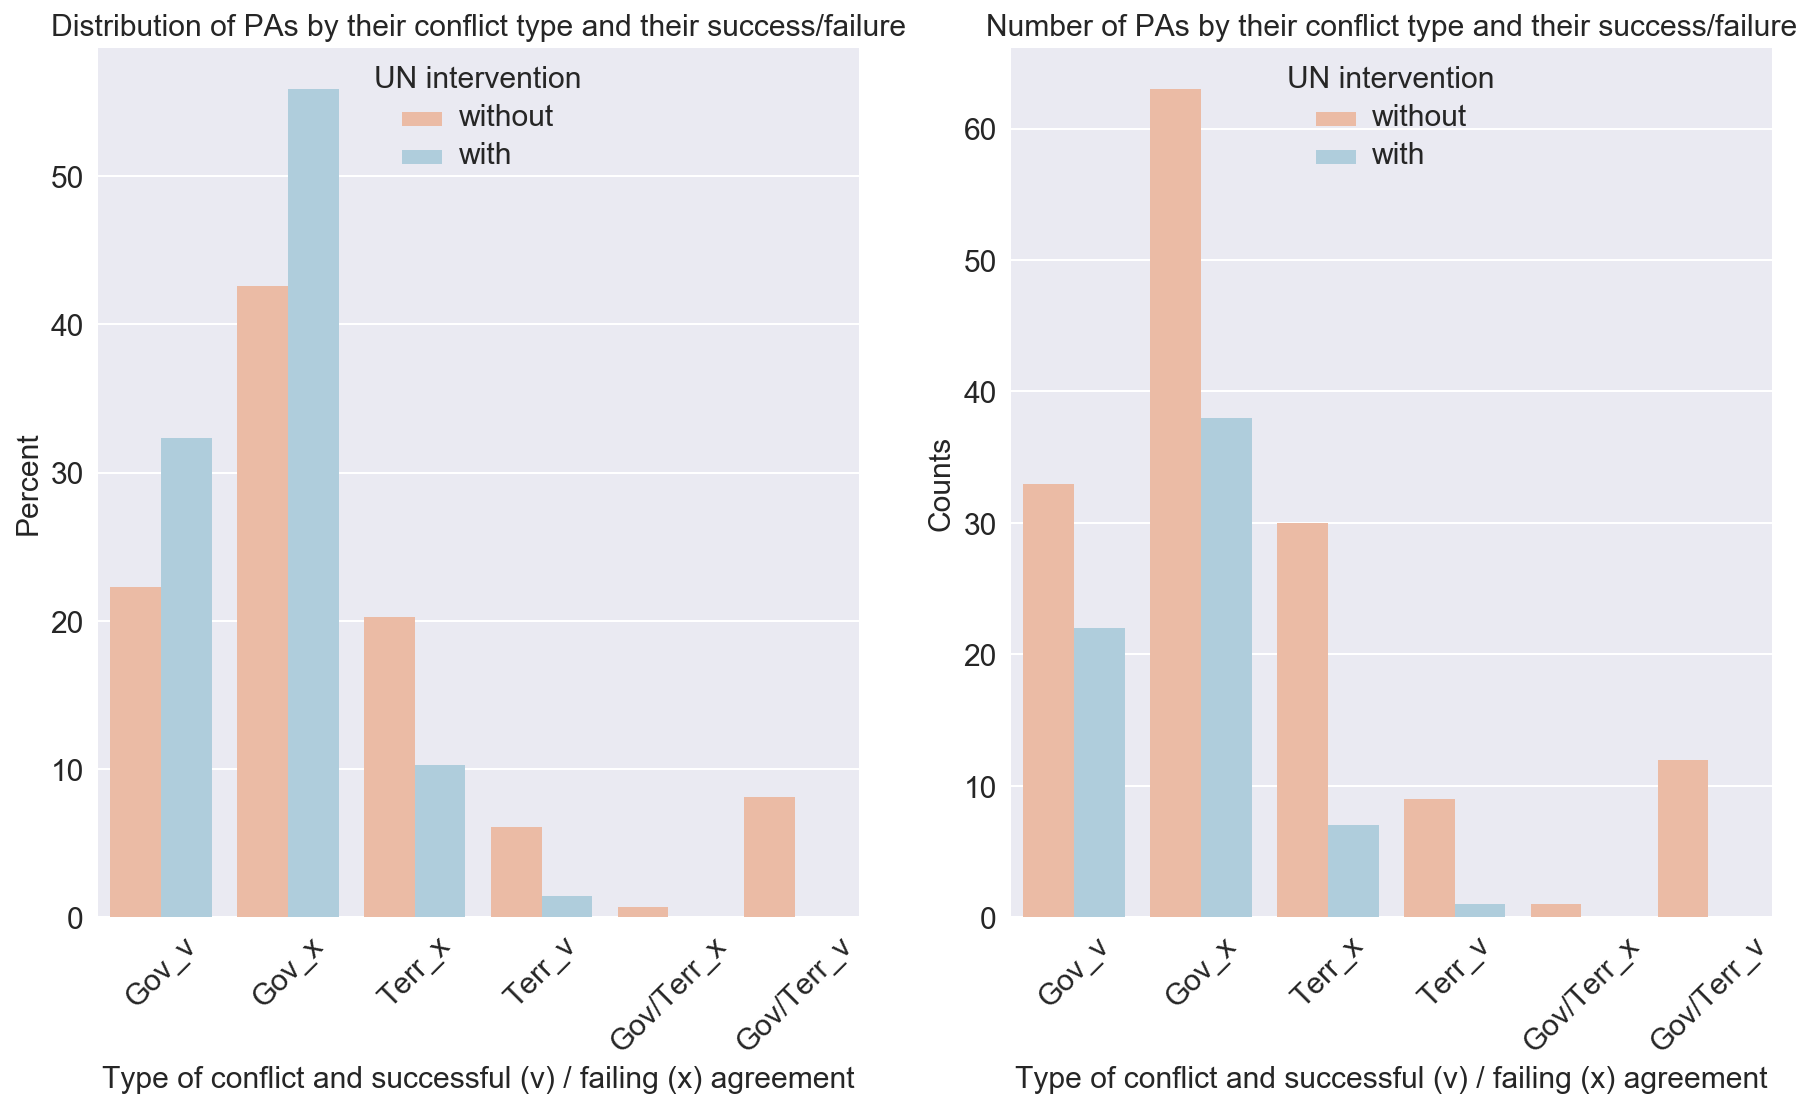

In [77]:
def create_category(x):
    if x.Inc == 'Governmental' and x.ended == 'Still Valid':
        val = 'Gov_x'
    elif x.Inc == 'Governmental' and x.ended == 'Terminated':
        val = 'Gov_v'
    elif x.Inc == 'Territorial' and x.ended == 'Still Valid':
        val = 'Terr_x'
    elif x.Inc == 'Territorial' and x.ended == 'Terminated':
        val = 'Terr_v'  
    elif x.Inc == 'Territorial & Governmental' and x.ended == 'Still Valid':
        val = 'Gov/Terr_x'
    else:
        val = 'Gov/Terr_v' 
    return val
pa['Inc_eval'] = pa.apply(create_category,axis=1)
percent_categorical('Inc_eval', df=pa, grouper='UN', order=pa.Inc_eval.unique(),
                    title = ['Distribution of PAs by their conflict type and their success/failure' , 'Number of PAs by their conflict type and their success/failure'],
                    label = 'Type of conflict and successful (v) / failing (x) agreement' , 
                    legend = ['UN intervention' , 'without' , 'with']);
plt.savefig('frontend/img/images/PA_Inc.png', transparent=True, bbox_inches='tight')

In [ ]:
pa.Inc_eval.value_counts()

----------- faire tableau -----------
- type of incompatibility \ success rate
- Governmental \ 0.65
- Territorial  \ 0.78
- Gov & Terr   \ 0.07

------------ faire tableau ----------

The figure above shows that UN is more involved in governmental conflicts than territorial ones and has a higher percentage of success than ones where it is not involved. The UN never took part to Peace Agreements supposing to settle governmental and territorial conflicts. The governmental and territorial conflicts are the ones with the lowest success rate.

In [72]:
pa.Justice_prov.value_counts()
130/216
justice = {0:'No provision', 1:'Provision'}
pa['Justice_prov'].replace(justice, inplace=True)

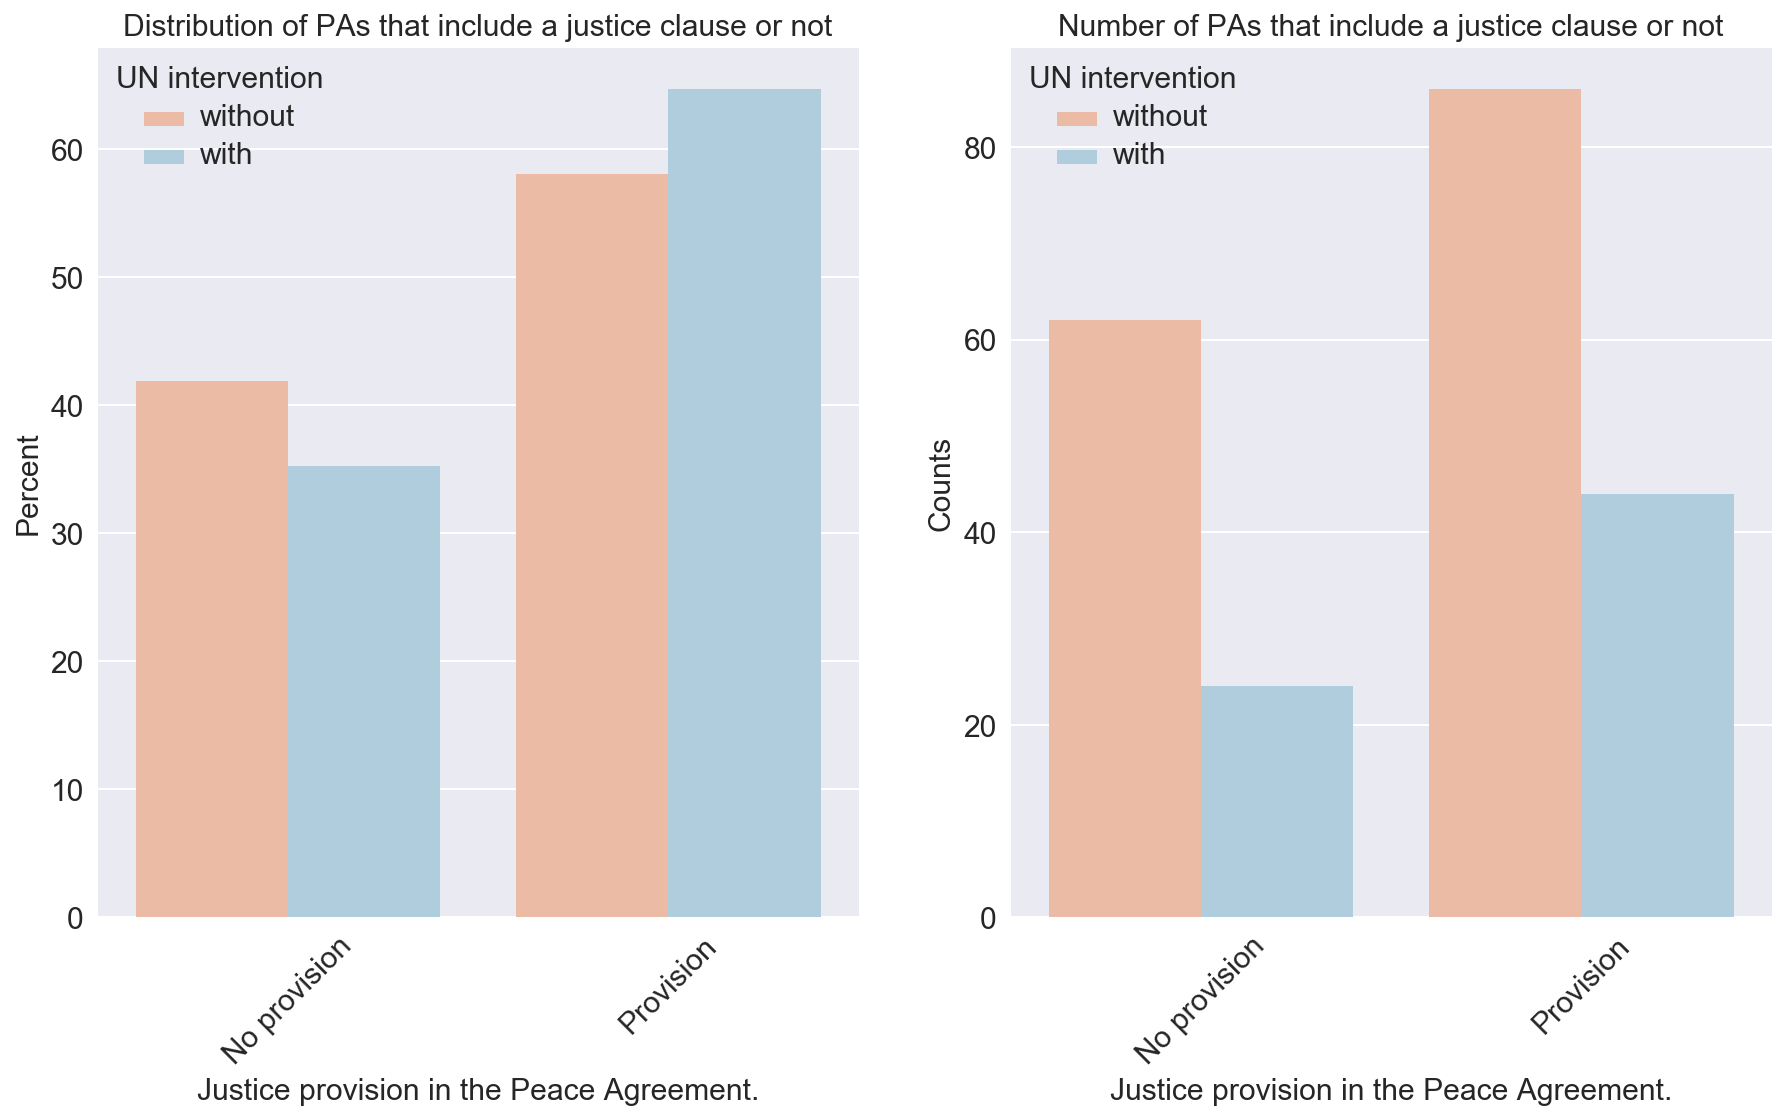

In [75]:
percent_categorical('Justice_prov', df=pa, grouper='UN', order=pa.Justice_prov.unique(),
                    title = ['Distribution of PAs that include a justice clause or not' , 'Number of PAs that include a justice clause or not'],
                    label = 'Justice provision in the Peace Agreement.' , 
                    legend = ['UN intervention' , 'without' , 'with']);
plt.savefig('frontend/img/images/PA_Justice.png', transparent=True, bbox_inches='tight')

### Regulation of justice issues
60% of the Peace agreemenets contain a clause concerning justice. The most recurring clause is the release of prisoners. 
# 3. Impact of the UN

The UN is present in 31% of the agreements and took part to at least one PA for 27 conflicts.

In this part, we will explore if the Peace Agreements where the United Nations acted as a third party performed better than the peace agreements where the UN did not act.

In order to do so, we will check the proportion of peace agreements that are ended in both cases.

In [ ]:
pa.groupby('UN').count()
pa.groupby(['UN' , 'ended']).count()

In [ ]:
pa[pa["UN"] ==1].groupby('CID').count()
pa.groupby('CID').count()

## A naive analysis

First, let's just compute the proportions straight from our Peace Agreements database.  

We observe that 34% of the agreements that included the UN ended, this proportion goes up to 36% for the agreements that did not include the UN. A chi square two-sample proportion test gives us a p-value of 0.82 so we don't reject the null hypothesis that these proportions are equal. This totally naive analysis can't give us a conclusion to our problematic, we can not say anything about the UN performances at this point.

In [ ]:
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]
pa[pa['UN'] == 1]

reader = csv.reader(open('data/translate_conf.csv', 'r'))

#Create a dictionnary that will have {New ID : Old ID} so we can make the link
d = {}
for row in reader:
    k, v = row
    d[v] = k
    
#pa.CID = pa.CID.astype(dtype=str).replace(to_replace=d )
pa.CID = pa.CID.astype(str)
#print(type(pa.CID))
pa.CID = pa.CID.apply(lambda x: d[x])
pa.CID = pa.CID.astype(dtype = int)

endeddic = {0: 'Active' , 1: 'Broken'}
pa.ended.replace(endeddic , inplace= True)


pa.groupby(['UN' , 'ended']).count()

In [ ]:
from scipy import stats
matrix = np.array([[94,45], [54, 23]])
stats.chi2_contingency(matrix)

In [ ]:
#without matching
percent_categorical('ended', df=pa, grouper='UN' , 
                   order = ['Active' , 'Broken'] , title = ['Disitribution of the state of the PAs' , 'Number of PAs per classes'],
                   label = 'State of the PA',
                   legend = ['UN intervention' , 'without' , 'with'])

plt.savefig('images/naive.png', transparent=True , bbox_inches = 'tight')

## After performing a propensity score matching on the Peace Agreements

Our previous analysis was quite naive as we saw on the earlier part about the PAs that they are not equally dristributed accross the two classes that are UN / not UN.

In order to solve this problem, we decided to perform a propensity score matching among the PAs, having the UN involvment as a treatment. To do so, we matched the 68 UN peace agreements using a propensity score mathing algorithm (you can check our notebook for further details).

We observe that, after these PAs are matched we have that only 30% of the agreements that did not include the UN ended. With this analysis, ee could think that the UN is performing worst than the other 3rd parties. But it is important to remember that we matched the PAs according to the caracteristics of the peace agreements, not the caracteristics of the conflicts. This means our analysis is still biased as we saw in the first part of this story that the UN solved conflicts that were more deadly and governmental than the other 3rd parties.

Let's perform the matching on the conflicts as well to conclude our analysis.

In [ ]:
#Matching on the PAs

pa = pd.read_excel('data/ucdp-peace-agreements.xls')
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]
pa[pa['UN'] == 1]

reader = csv.reader(open('data/translate_conf.csv', 'r'))

#Create a dictionnary that will have {New ID : Old ID} so we can make the link
d = {}
for row in reader:
    k, v = row
    d[v] = k
    
#pa.CID = pa.CID.astype(dtype=str).replace(to_replace=d )
pa.CID = pa.CID.astype(str)
#print(type(pa.CID))
pa.CID = pa.CID.apply(lambda x: d[x])
pa.CID = pa.CID.astype(dtype = int)


cols = ['bwdID', 'pa_comment', 'c_sign', 'c_3rd', 'c_duration', 'Reaffirm ID', 'Comment', 'txt', 
        'Link to fulltext agreement', 'ProcID', 'Frame', 'All', 'Counter' , 'Duration']
pa.drop(columns=cols, inplace=True)
to_be_categorical = ['termdur' , 'noconf11' , 'CoVi01' ,'DyVi05' ]
for categ in to_be_categorical:
    pa[categ] = pd.Categorical(pa[categ] , pa[categ].unique())

In [ ]:
pa_reg = pa.iloc[:, 13:-1]
#prepocess by standardizing the dataset
pa_reg = preprocessing.scale(pa_reg)
#Perform a logistic regression in order to get the propensity score for each individuals
model = sklearn.linear_model.LogisticRegression()
model.fit(pa_reg, pa.UN)
pred = model.predict_proba(pa_reg)
pa['pred'] = pred[:,1]
G=nx.Graph()
G.add_nodes_from(pa['PAID'][pa.UN == 0])
G.add_nodes_from(pa['PAID'][pa.UN == 1])
for ID_u, score_u in zip(pa.PAID[pa.UN == 0], pa.pred[pa.UN == 0]):
    for ID_v, score_v in zip(pa.PAID[pa.UN == 1], pa.pred[pa.UN == 1]):
        G.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))
matching = max_weight_matching(G, maxcardinality=True)
pa_UN = pa[pa['UN'] == 1]
pa_UN['temp'] = 1
pa_UN = pa_UN[['PAID' , 'pred' , 'temp']]
pa_nUN = pa[pa['UN'] == 0]
pa_nUN['temp'] = 1
pa_nUN = pa_nUN[['PAID' , 'pred' , 'temp']]


#We merge the two datasets thanks to the temp column, this new merged dataset mimics the complete bipartite graph:
result = pd.merge(pa_nUN ,pa_UN , on='temp', how='left')
result = result[['PAID_x' , 'PAID_y' , 'pred_x' , 'pred_y']]
result['diff'] = abs(result['pred_x'] - result['pred_y'])
result = result.set_index(['PAID_x', 'PAID_y'])
result['diff'].isnull().values.any()
paID = pa.set_index('PAID')
matched = paID.loc[list(matching.keys())]

In [ ]:
pa.iloc[:, 13:-1].head()

In [ ]:
endeddic = {0: 'Active' , 1: 'Broken'}
matched.ended.replace(endeddic , inplace= True)


percent_categorical('ended', df=matched, grouper='UN' , 
                   order = ['Active' , 'Broken'] , title = ['Disitribution of the state of the PAs' , 'Number of PAs per classes'],
                   label = 'State of the PA',
                   legend = ['UN intervention' , 'without' , 'with'])



#percent_categorical('ended', df=matched, grouper='UN')
plt.savefig('images/lessnaive.png', transparent=True,  bbox_inches = 'tight')
#result.loc[list(matching.items())].dropna().head()

In [ ]:
matched.groupby(['UN' , 'ended']).count()

In [ ]:
matrix = np.array([[47,45], [21, 23]])
stats.chi2_contingency(matrix)

## When matching on the conflicts as well

When matching on the conflicts as well, we observe that 42% of the conflicts solved by another 3rd party than the UN failed. This is way higher than the fail rate of the UN that is of 33%. Performing a chi-square two sample test for equality of the proportion, we have a p-value of XXX . 

When matching on the conflicts, we observe that the UN peace agreements are way more stable than the ones performed by other 3rd parties. Indeed, we observed in the previous parts that the UN was taking care of a larger part of deadly governmental conflicts compared to the other 3rd parties.

A naive analysis first showed us that the UN was performing as good as other 3rd parties if not worst, but when pushing this observational study further we showed that it is bringing more stability when it is involved in the resolution of a conflict.

In [ ]:
agreements = pa.groupby('CID').last()
print('Number of unique conflicts that had a peace agreement : %s' %(len(agreements.index)))
UN_agreements = pa[pa['UN']==1].groupby('CID').last()
Other_agreements = pa[pa['UN']==0].groupby('CID').last()
print('Number of unique conflicts that had a UN peace agreement : %s' %(len(UN_agreements.index)))
print('Number of unique conflicts that had a peace agreement that did not involve the UN: %s' %(len(Other_agreements.index)))
clean_df["agreement"] = [1 if ele in agreements.index else 0 for ele in clean_df.index]
clean_df["UN_agreement"] = [1 if ele in UN_agreements.index else 0 for ele in clean_df.index]
clean_df["Other_agreement"] = [1 if ele in Other_agreements.index else 0 for ele in clean_df.index]
pa_UN_CID = pa.loc[pa['CID'].isin(clean_df[clean_df['UN_agreement'] == 1].index)]

pa_UN_CID.ended.replace(endeddic , inplace= True)

In [ ]:
percent_categorical('ended', df=pa_UN_CID, grouper='UN' , 
                   order = ['Active' , 'Broken'] , title = ['Disitribution of the state of the PAs' , 'Number of PAs per classes'],
                   label = 'State of the PA',
                   legend = ['UN intervention' , 'without' , 'with'])
plt.savefig('images/notnaive.png', transparent=True, bbox_inches = 'tight')

In [ ]:
pa_UN_CID[pa_UN_CID['UN'] == 1]
pa_UN_CID.groupby('CID').count().shape

In [ ]:
pa_UN_CID.groupby(['UN' , 'ended']).count()

In [ ]:
matrix = np.array([[40,45], [29, 23]])
stats.chi2_contingency(matrix)

In [ ]:
import math
n1 = 69
n2 = 68
y1 = 29
y2 = 23
p1 = y1/n1
p2 = y2/n2
phat = (y1 + y2)/(n1 + n2)
Z = (p1 - p2) / math.sqrt(phat * (1 - phat) * ((1/n1) + (1/n2)))
Z2 = (p1 - p2) / math.sqrt( ((p1 * (1-p1))/n1)  + ((p2 * (1-p2))/n2))
print(p1 , p2 , phat)
print(Z)
print(Z2)

In [ ]:
oddsratio, pvalue = stats.fisher_exact([[40, 45], [29, 23]])
pvalue

# 4. Map
We created an interactive interface to present a wide view of the conflicts around the world with the possibility to get a deep insight into one conflict. It allows the user to travel trhough time and observe the evolution of conflicts and peace agreements around the world. The user can get deeper information on a conflict and its Peace Agreements in the right bar.

# 5. Conclusions
Our study showed that...
In the domain of conflict resolution, our study proved that the UN have a positive impact. IT should be noted that UN biggest challenges does not land in the resolution of existing conflicts but rather in the settlement of communication channels to avoid the creation of tensions between countries. For further research, An analysis of the interactions between state leaders and the tension level between countries. 
chef d'états en tension level between contries. 